In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import gdal

# Loading the selected basins

The selected basins were selected randomly.

In [2]:
NLD_boundaries = gpd.read_file('NLD_shapefile/gadm36_NLD_0.shp')

selected_basins = gpd.read_file('Basins_NLD/selected_basins/selected_basins.shp')
# Find the centroids
selected_basins['centroid_x'] = selected_basins.geometry.centroid.x
selected_basins['centroid_y'] = selected_basins.geometry.centroid.y
selected_basins_centroids = selected_basins.copy()
selected_basins_centroids = gpd.GeoDataFrame(
    selected_basins_centroids, geometry=gpd.points_from_xy(selected_basins_centroids['centroid_x'], selected_basins_centroids['centroid_y']))

C:\Users\ilias\AppData\Local\Temp/ipykernel_15476/1532972488.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  selected_basins['centroid_x'] = selected_basins.geometry.centroid.x
C:\Users\ilias\AppData\Local\Temp/ipykernel_15476/1532972488.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  selected_basins['centroid_y'] = selected_basins.geometry.centroid.y


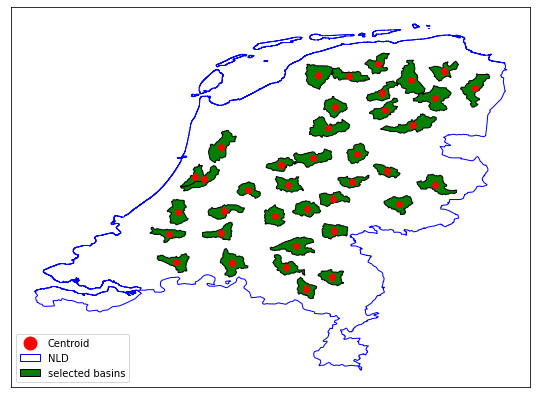

In [3]:
#Basins with their centroids
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
red_circle = Line2D([0], [0], marker='o', color='w', label='Centroid', markerfacecolor='r', markersize=15)
LegendElement = [red_circle,
                 mpatches.Patch(facecolor='None', edgecolor='blue', label='NLD'),
                 mpatches.Patch(facecolor='green', edgecolor='black', label='selected basins')]

fig, ax  = plt.subplots()
fig.set_size_inches(16, 7, forward=True)
selected_basins.plot(facecolor='green', edgecolor='black', ax=ax)
NLD_boundaries.plot(facecolor='None', edgecolor='blue', ax=ax)
selected_basins_centroids.plot(color='red', ax=ax)
ax.legend(handles = LegendElement, loc='lower left')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([]);

# Loading the weather stations

In [4]:
weather_stations = pd.read_csv('weather_stations/KNMI_weather_stations.txt', delimiter=';')
weather_stations.head()
weather_stations.columns = ['station', 'lat', 'lon', 'alt', 'name']
weather_stations.head()

,station,lat,lon,alt,name
0,391,6.197,51.498,19.5,ARCEN
1,370,5.377,51.451,22.6,EINDHOVEN
2,331,4.193,51.480,0.0,THOLEN
3,315,3.998,51.447,0.0,HANSWEERT
4,324,4.006,51.596,0.0,STAVENISSE


In [5]:
weather_stations_gdf = gpd.GeoDataFrame(
    weather_stations, geometry=gpd.points_from_xy(weather_stations.lat, weather_stations.lon))
# weather_stations = weather_stations.set_crs(4326)

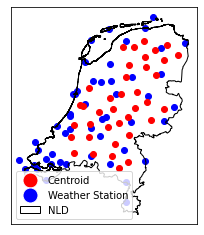

In [6]:
blue_circle = Line2D([0], [0], marker='o', color='w', label='Weather Station', markerfacecolor='b', markersize=15)
LegendElement = [red_circle,
                 blue_circle,
                 mpatches.Patch(facecolor='None', edgecolor='black', label='NLD'),]

fig.set_size_inches(18, 12, forward=True)
fig, ax  = plt.subplots()
weather_stations_gdf.plot(color='blue', ax=ax)
selected_basins_centroids.plot(color='red', ax=ax)
NLD_boundaries.plot(facecolor='None', edgecolor='black', ax=ax)

ax.legend(handles = LegendElement, loc='lower left')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([]);

# Calculation

Finding the nearest weather station for each basin centroid

In [7]:
def min_dist(point, gpd2):
    gpd2['Dist'] = gpd2.apply(lambda row:  point.distance(row.geometry),axis=1)
    nearest_row = gpd2.iloc[gpd2['Dist'].argmin()]
    return nearest_row

In [8]:
selected_basins_centroids['Nearest'] = selected_basins_centroids.apply(lambda row:
                                                                       min_dist(row.geometry,weather_stations_gdf)['name'] ,
                                                                       axis=1)

In [9]:
selected_basins_centroids.head(2)

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,centroid_x,centroid_y,Nearest
0,2120366740,2120367860,2120023220,2120023220,12.0,12.0,209.2,209.2,232701040600,0,0,2,34257,POINT (4.88821 52.55104),4.888210,52.551041,BERKHOUT
1,2120380390,2120381010,2120023010,2120023010,31.2,31.2,169.3,169.4,232610150200,0,0,2,32985,POINT (4.53472 52.01466),4.534718,52.014662,ROTTERDAM


In [10]:
selected_basins_centroids.Nearest.unique()

array(['BERKHOUT', 'ROTTERDAM', 'EINDHOVEN', 'LEEUWARDEN', 'VOLKEL',
       'MARKNESSE', 'CABAUW', 'SOESTERBERG', 'EELDE', 'HUPSEL', 'DEBILT',
       'WOENSDRECHT', 'HOOGEVEEN', 'HEINO', 'LAUWERSOOG', 'DEELEN',
       'GILZE-RIJEN', 'LELYSTAD', 'NIEUWBEERTA', 'SCHIPHOL'], dtype=object)

In [11]:
len(selected_basins_centroids.Nearest.unique())

20

<AxesSubplot:>

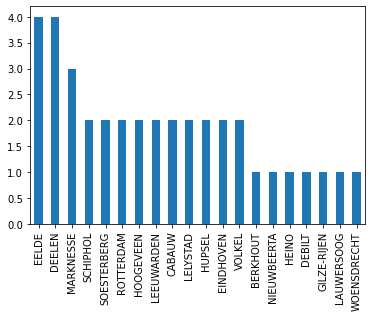

In [12]:
selected_basins_centroids.Nearest.value_counts().plot(kind='bar')

### Some weather stations were assigned to more than one basin. This could create high correlation which would be wrong; therefore, only one weather station was used for each basin. The rest were deleted. 

In [13]:
selected_basins_centroids.shape

(38, 17)

In [14]:
selected_basins_centroids.drop_duplicates(subset=['Nearest'], inplace=True)

Afterwards, the weather stations which were not selected in the previous step were determined. The basins which contain the former were selcted and added to the abalysis given that they have not selected at the beginning.

Find the weather stations which have not been used

In [15]:
selected_basins_centroids.Nearest.unique()

array(['BERKHOUT', 'ROTTERDAM', 'EINDHOVEN', 'LEEUWARDEN', 'VOLKEL',
       'MARKNESSE', 'CABAUW', 'SOESTERBERG', 'EELDE', 'HUPSEL', 'DEBILT',
       'WOENSDRECHT', 'HOOGEVEEN', 'HEINO', 'LAUWERSOOG', 'DEELEN',
       'GILZE-RIJEN', 'LELYSTAD', 'NIEUWBEERTA', 'SCHIPHOL'], dtype=object)

In [16]:
remaining_weather_stations_names = set(weather_stations.name) - set(selected_basins_centroids.Nearest.unique())
len(remaining_weather_stations_names)

30

In [17]:
basins_NLD = gpd.read_file('Basins_NLD/basins_NLD_within.shp')
basins_NLD.shape

(209, 14)

In [18]:
basins_NLD.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
remaining_weather_stations = weather_stations[weather_stations.name.isin(remaining_weather_stations_names)]

<AxesSubplot:>

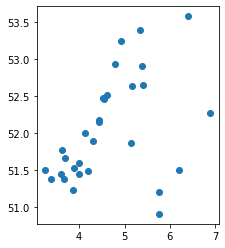

In [20]:
remaining_weather_stations_gdf = gpd.GeoDataFrame(remaining_weather_stations, crs=4326)
remaining_weather_stations_gdf.plot()

In [21]:
remaining_weather_stations_gdf.to_file("remaining_weather_stations_gdf.shp")

# Spatial join 

In [22]:
from geopandas.tools import sjoin
# remaining weather stations after spatial join rem_weather_stations_gdf_sjoin
rem_weather_stations_gdf_sjoin = sjoin(remaining_weather_stations_gdf, basins_NLD, how="inner", op="within")
rem_weather_stations_gdf_sjoin.dropna(subset=['name']).shape

(8, 21)

Many weather staions are located on the sea; this is the reason why the spatial join spotted a limited number of basins (i.e. 8 out of 20)

Checking if there are common elements between the two lists of weather stations. Based on the above-mentioned results, there are no weather stations which were used more than one.

In [23]:
def common_elements(list1, list2):
    return list(set(list1) & set(list2))

common_elements(selected_basins_centroids.Nearest.unique().tolist(), rem_weather_stations_gdf_sjoin.name.tolist())

[]

# Cleaning the data

In [24]:
selected_basins_centroids.head(2)

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,centroid_x,centroid_y,Nearest
0,2120366740,2120367860,2120023220,2120023220,12.0,12.0,209.2,209.2,232701040600,0,0,2,34257,POINT (4.88821 52.55104),4.888210,52.551041,BERKHOUT
1,2120380390,2120381010,2120023010,2120023010,31.2,31.2,169.3,169.4,232610150200,0,0,2,32985,POINT (4.53472 52.01466),4.534718,52.014662,ROTTERDAM


In [25]:
def Deleting_cols(df, array_keep_names):
    cols = df.columns.to_list()
    for i in array_keep_names:
        cols.remove(i)
    return df[array_keep_names]

In [26]:
output_1 = Deleting_cols(rem_weather_stations_gdf_sjoin, ['name', 'HYBAS_ID'])
output_1.columns = ['w_station_name', 'basin_name']
output_1.reset_index(drop=True, inplace=True)

In [27]:
output_2 = Deleting_cols(selected_basins_centroids, ['HYBAS_ID','Nearest'])
output_2.columns = ['basin_name', 'w_station_name']
output_2.reset_index(drop=True, inplace=True)

Merging the two dataframes

In [28]:
merge_file = pd.concat([output_1, output_2]).reset_index()
merge_file.drop(['index'], axis=1, inplace=True)

In [41]:
merge_file

,w_station_name,basin_name
0,STAVENISSE,2120022880
1,WILHELMINADORP,2120022860
2,VOORSCHOTEN,2121114020
3,R'DAM-GEULHAVEN,2120379680
4,TWENTHE,2120368930
5,VALKENBURG,2120023040
6,WIJDENES,2120023210
7,HERWIJNEN,2120382840
8,BERKHOUT,2120366740
9,ROTTERDAM,2120380390


In [29]:
merge_file.dtypes

w_station_name    object
basin_name         int64
dtype: object

In [30]:
#merge_file.basin_name

In [31]:
merge_file.basin_name.astype('str')    
basins_NLD.HYBAS_ID.astype('str')

0      2120023330
1      2120366900
2      2120367860
3      2120368080
4      2120367870
          ...    
204    2120400270
205    2120380180
206    2120368930
207    2121113530
208    2120378010
Name: HYBAS_ID, Length: 209, dtype: object

In [32]:
basins_NLD.HYBAS_ID.to_list

<bound method IndexOpsMixin.tolist of 0      2120023330
1      2120366900
2      2120367860
3      2120368080
4      2120367870
          ...    
204    2120400270
205    2120380180
206    2120368930
207    2121113530
208    2120378010
Name: HYBAS_ID, Length: 209, dtype: int64>

In [33]:
basins_NLD.head(2)

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
0,2120023330,0,2120023330,2120023330,0.0,0.0,4.2,4.2,232703010110,0,1,0,34368,"POLYGON ((5.64583 52.61667, 5.64548 52.61909, ..."
1,2120366900,2120367860,2120023220,2120023220,11.9,11.9,118.4,307.6,232701040710,0,0,1,34256,"POLYGON ((4.76250 52.56250, 4.76307 52.56471, ..."


In [34]:
basins_NLD_final = basins_NLD.loc[basins_NLD.HYBAS_ID.isin(merge_file.basin_name.to_list())]
basins_NLD_final.shape

(28, 14)

In [35]:
basins_NLD_final.to_file('Outputs/Final_selected_basins.shp')

In [36]:
# Keep only id for basin, id for weatehr station, and area

In [37]:
# Keep the geometry too

In [38]:
# I added some basins which have not been selected at the previous step.

In [39]:
# check if they have been selected

In [43]:
weather_stations

,station,lat,lon,alt,name,geometry,Dist
0,391,6.197,51.498,19.5,ARCEN,POINT (6.19700 51.49800),1.679829
1,370,5.377,51.451,22.6,EINDHOVEN,POINT (5.37700 51.45100),1.203746
2,331,4.193,51.480,0.0,THOLEN,POINT (4.19300 51.48000),1.276889
3,315,3.998,51.447,0.0,HANSWEERT,POINT (3.99800 51.44700),1.418231
4,324,4.006,51.596,0.0,STAVENISSE,POINT (4.00600 51.59600),1.300152
5,375,5.707,51.659,22.0,VOLKEL,POINT (5.70700 51.65900),1.210849
6,380,5.762,50.906,114.3,MAASTRICHT,POINT (5.76200 50.90600),1.862705
7,240,4.790,52.318,-3.3,SCHIPHOL,POINT (4.79000 52.31800),0.252889
8,286,7.150,53.196,-0.2,NIEUWBEERTA,POINT (7.15000 53.19600),2.351950
9,310,3.596,51.442,8.0,VLISSINGEN,POINT (3.59600 51.44200),1.702873


In [44]:
merge_file

,w_station_name,basin_name
0,STAVENISSE,2120022880
1,WILHELMINADORP,2120022860
2,VOORSCHOTEN,2121114020
3,R'DAM-GEULHAVEN,2120379680
4,TWENTHE,2120368930
5,VALKENBURG,2120023040
6,WIJDENES,2120023210
7,HERWIJNEN,2120382840
8,BERKHOUT,2120366740
9,ROTTERDAM,2120380390


For the rest weather stations. just select the basins on which tehy are located

# Merge the two groups of basins

In [49]:
merge_file_V3 = pd.merge(merge_file, weather_stations, left_on='w_station_name', right_on='name').reset_index()
merge_file_V3.sort_values(by='station')

,index,w_station_name,basin_name,station,lat,lon,alt,name,geometry,Dist
5,5,VALKENBURG,2120023040,210,4.430,52.171,-0.2,VALKENBURG,POINT (4.43000 52.17100),0.595304
2,2,VOORSCHOTEN,2121114020,215,4.437,52.141,-1.1,VOORSCHOTEN,POINT (4.43700 52.14100),0.609691
27,27,SCHIPHOL,2120372120,240,4.790,52.318,-3.3,SCHIPHOL,POINT (4.79000 52.31800),0.252889
6,6,WIJDENES,2120023210,248,5.174,52.634,0.8,WIJDENES,POINT (5.17400 52.63400),0.297588
8,8,BERKHOUT,2120366740,249,4.979,52.644,-2.4,BERKHOUT,POINT (4.97900 52.64400),0.129940
18,18,DEBILT,2120371920,260,5.180,52.100,1.9,DEBILT,POINT (5.18000 52.10000),0.537196
15,15,SOESTERBERG,2120370440,265,5.274,52.130,13.9,SOESTERBERG,POINT (5.27400 52.13000),0.571060
25,25,LELYSTAD,2120365010,269,5.520,52.458,-3.7,LELYSTAD,POINT (5.52000 52.45800),0.638604
11,11,LEEUWARDEN,2120349340,270,5.752,53.224,1.2,LEEUWARDEN,POINT (5.75200 53.22400),1.094992
13,13,MARKNESSE,2121109010,273,5.888,52.703,-3.3,MARKNESSE,POINT (5.88800 52.70300),1.011273


In [50]:
merge_file_V3.shape

(28, 10)

# checking differences